Utilize o dataset MNIST.

Realize a classificação utilizando o kNN, Decision Tree e Random Forest, Naive Bayes Gaussiano e calcule algumas métricas.

Utilize o K-means. Realize experimentos com 10 clusters e uma quantidade incorreta de clusters.

Realize diferentes experimentos, mudando o k do kNN (utilize o GridSearch), o número de florestas no Random Forest (utilize o RandomSearch), e o ‘critério’ do Decision Tree (utilize o GridSearch).

Utilize o t-SNE para redução de dimensionalidade.

Realize a normalização e padronização dos dados, utilize o melhor classificador.

Discuta os resultados.


## Importação dos dados

In [2]:
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
(X_train,y_train), ( X_test, y_test) = keras.datasets.mnist.load_data()


In [4]:
X_train = np.reshape(X_train, (60000,784))
X_test = np.reshape(X_test, (10000,784))

## Normalizando e padronizando os dados

In [5]:
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)
transformer = Normalizer().fit(X_test)
X_test = transformer.transform(X_test)

In [5]:
transformer = StandardScaler().fit(X_train)
X_train = transformer.transform(X_train)
transformer = StandardScaler().fit(X_test)
X_test = transformer.transform(X_test)

## Funções

In [21]:
def KNN(X_train, y_train, n):
    modelo = KNeighborsClassifier(n_neighbors=n)
    return modelo.fit(X_train, y_train)

def decision_tree(X_train, y_train, c):
    modelo = DecisionTreeClassifier(criterion=c)
    return modelo.fit(X_train, y_train)

def random_forest(X_train, y_train, n):
    modelo = RandomForestClassifier(n_estimators=n)
    return modelo.fit(X_train, y_train)

def vector_classificator(X_train, y_train):
    modelo = SVC()
    return modelo.fit(X_train, y_train)

def naive_bayes_gaussian(X_train, y_train):
    modelo = GaussianNB()
    return modelo.fit(X_train, y_train)

def k_means(X_train,n):
    modelo = KMeans(n_clusters=n)
    return modelo.fit(X_train)
def print_matriz_confusao(y_test, y_predict):
    cm = confusion_matrix(y_test, y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

## Treinando modelo

### Classificação por K-Vizinhos 

In [25]:
modelo_knn = KNN(X_train, y_train, 3)
knn_predict = modelo_knn.predict(X_test)

In [26]:
print('Precisão')
print(accuracy_score(y_test, knn_predict))
print('Resumo')
print(classification_report(y_test, knn_predict))

Precisão
0.9733
Resumo
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       980
           1       0.97      1.00      0.98      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Classificação por arvore de decisão

In [12]:
modelo_decision_tree = decision_tree(X_train, y_train, 'gini')
decision_tree_predict = modelo_decision_tree.predict(X_test)

In [14]:
print('Precisão')
print(accuracy_score(y_test,decision_tree_predict))
print('Resumo')
print(classification_report(y_test,decision_tree_predict))

Precisão
0.8786
Resumo
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       980
           1       0.96      0.96      0.96      1135
           2       0.86      0.85      0.85      1032
           3       0.83      0.85      0.84      1010
           4       0.88      0.89      0.88       982
           5       0.83      0.84      0.84       892
           6       0.89      0.88      0.89       958
           7       0.92      0.90      0.91      1028
           8       0.82      0.81      0.81       974
           9       0.86      0.86      0.86      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Classificação por floresta aleatória

In [17]:
modelo_random_forest = random_forest(X_train, y_train, 75)
random_forest_predict = modelo_random_forest.predict(X_test)

In [18]:
print('Precisão')
print(accuracy_score(y_test, random_forest_predict))
print('Resumo')
print(classification_report(y_test, random_forest_predict))

Precisão
0.9695
Resumo
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Classificação SVC

In [31]:
modelo_svc = vector_classificator(X_train, y_train)
svc_predict = modelo_svc.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, svc_predict))

Precisão
0.9792


### Classificação Naive Bayes Gaussian

In [34]:
modelo_bayes_gaussian = naive_bayes_gaussian(X_train, y_train)
nbg_predict = modelo_bayes_gaussian.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, nbg_predict))

Precisão
0.5558


### Cluster Kmeans

In [24]:
modelo = k_means(X_train, 10)
y_predict = modelo.predict(X_test)

In [70]:
df = pd.DataFrame(y_predict, columns = ['Column_A'])

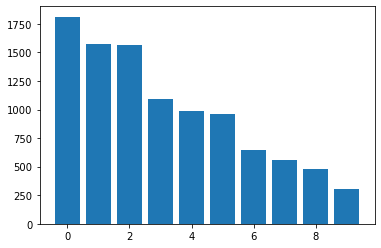

In [65]:
plt.bar([x for x in range(10)], df['Column_A'].value_counts())
plt.show()

## Melhorando os classificadores

### KNN melhorado

In [9]:
best_precision_knn = 0.9705
k_vizinhos = 3
for i in range(5,9, 2):
    new_modelo_knn = KNN(X_train, y_train, i)
    new_predict = new_modelo_knn.predict(X_test)
    precision = accuracy_score(y_test, new_predict)
    if precision > best_precision_knn:
        best_precision_knn = precision
        k_vizinhos = i

print(f'A melhor precisão do KNN foi {best_precision_knn} com o numero de vizinhos igual a {k_vizinhos}')

A melhor precisão do KNN foi 0.9705 com o numero de vizinhos igual a 3


### Arvore de decisão melhorada

In [18]:
best_precision_decision_tree = 0.8765
criterio = 'gini'

new_modelo_decision_tree = decision_tree(X_train, y_train, 'entropy')
new_decision_tree_predict = new_modelo_decision_tree.predict(X_test)

new_decision_tree_precision = accuracy_score(y_test, new_decision_tree_predict)

if new_decision_tree_precision > best_precision_decision_tree:
    best_precision_decision_tree = new_decision_tree_precision
    criterio = 'entropy'

print(f'Melhor critério de decisão para arvore de decisão é {criterio} com precisão de {best_precision_decision_tree}')

Melhor critério de decisão para arvore de decisão é entropy com precisão de 0.8857


### Floresta aleatória melhorada

In [20]:
best_precision_random_florest = 0.9695
num_arvores = 75
for i in range(100,200, 25):
    new_modelo_random_forest = random_forest(X_train, y_train, i)
    new_predict = new_modelo_random_forest.predict(X_test)
    precision = accuracy_score(y_test, new_predict)
    if precision > best_precision_random_florest:
        best_precision_random_florest = precision
        num_arvores = i

print(f'Quantidade de arvores para obter melhor precisão na Floresta Aleatória é {num_arvores} com valor de {best_precision_random_florest}')

Quantidade de arvores para obter melhor precisão na Floresta Aleatória é 175 com valor de 0.9716


## Plot Decision Surface

In [49]:
modelo = TSNE(n_components=2, random_state=0)
X_train_tsne = modelo.fit_transform(X_train[1:10000,:])

<function matplotlib.pyplot.show(close=None, block=None)>

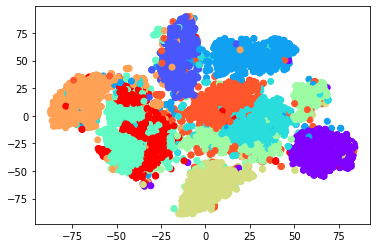

In [58]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:,1], c=y_train[1:10000],cmap='rainbow')
plt.show

## Testes com normalização

In [67]:
modelo_knn = KNN(X_train_processed, y_train, 3)
knn_predict = modelo_knn.predict(X_test_processed)
print('Precisão')
print(accuracy_score(y_test, knn_predict))

Precisão
0.9441


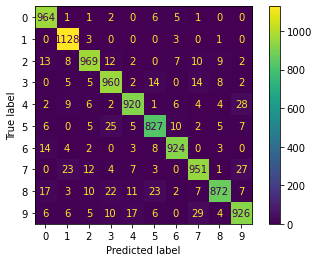

In [69]:
print_matriz_confusao(y_test, knn_predict)

In [26]:
modelo_decision_tree = decision_tree(X_train_processed, y_train, 'entropy')
decision_tree_predict = modelo_decision_tree.predict(X_test_processed)
print('Precisão')
print(accuracy_score(y_test, decision_tree_predict))

Precisão
0.8377


In [27]:
modelo_random_forest = random_forest(X_train_processed, y_train,175)
random_florest_predict = modelo_random_forest.predict(X_test_processed)
print('Precisão')
print(accuracy_score(y_test, random_florest_predict))

Precisão
0.9618


## Melhorando classificadores parte 2

### Grid Search with KNN

In [13]:
lista = [x for x in range(3,16,2)]
params = {'n_neighbors':lista}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params)
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15]})

In [16]:
predict = clf.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, predict))

Precisão
0.9705


### Random Search with Random Forest

In [33]:
lista = [x for x in range(25,176,25)]
modelo = RandomForestClassifier()
params = {'n_estimators':lista}
clf = RandomizedSearchCV(modelo, params, n_iter=3)
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=1, n_jobs=-1,
                   param_distributions={'n_estimators': [25, 50, 75, 100]})

In [34]:
predict = clf.predict(X_test)
print('Precisao')
print(accuracy_score(y_test, predict))

Precisao
0.9628


### Random search Decision tree 

In [6]:
modelo = DecisionTreeClassifier()
params = {'splitter':['best', 'random'], 'criterion':['gini','entropy']}
clf = RandomizedSearchCV(modelo, params, n_iter=3)
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=3,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'splitter': ['best', 'random']})

In [7]:
y_predict = clf.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, y_predict))

Precisão
0.883
